In [1]:
import pandas as pd 
import numpy as np 
from collections import Counter 
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import re

import nltk
from nltk.tokenize import word_tokenize 
nltk.download('punkt')
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer 
nltk.download('wordnet')
from nltk.corpus import stopwords

from wordcloud import WordCloud 

from sklearn.utils import resample
from sklearn.decomposition import TruncatedSVD 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import v_measure_score
from sklearn.metrics.cluster import adjusted_rand_score
import sklearn.metrics
from sklearn.cluster import AgglomerativeClustering
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora

import string

from textblob import TextBlob

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\cafe6\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\cafe6\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
def rm_punct_symb(phrase):
    phrase_no_punct = "".join([i for i in phrase if i not in string.punctuation])
    return phrase_no_punct

# Data preparation

In [3]:
# Importazione dataset e riconversione colonna in lista di stringhe, come già fatto nel preprocessing

df = pd.read_csv('C:/Users/cafe6/Documents/GitHub/Dati TextMining/df_lemmatized.csv')
df['Lemmatized Text'] = df['Lemmatized Text'].apply(rm_punct_symb)
df['Lemmatized Text'] = df['Lemmatized Text'].str.split(' ')

In [4]:
# Mantengo solo le colonne necessarie al clustering

clust_df = df[['Lemmatized Text', 'Score']]

In [5]:
clust_df.head()

,Lemmatized Text,Score
0,"[bought, several, vitality, canned, dog, food,...",5
1,"[product, arrived, labelled, lumbo, halted, pe...",1
2,"[connection, around, century, light, pillow, c...",4
3,"[looking, secret, ingredient, robitussin, beli...",2
4,"[great, staff, great, price, wide, assortment,...",5


Sappiamo che le review sono sbilanciate verso la classe '4' e '5': procedo al downsampling.

Text(0, 0.5, 'Number of reviews')

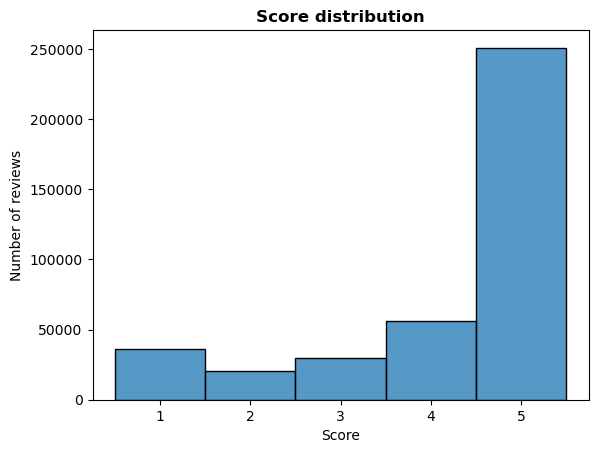

In [6]:
sns.histplot(clust_df['Score'], discrete=True)
plt.title("Score distribution", fontweight='bold')
plt.xlabel("Score")
plt.ylabel("Number of reviews")

In [7]:
sample_size = clust_df.groupby('Score').count().min()[0] # Prendo come dimensione quella minima fra tutte le classi

df_downsampled = clust_df.groupby('Score', group_keys=False).apply(lambda x: x.sample(sample_size))
df_downsampled

,Lemmatized Text,Score
67467,"[im, going, say, chip, taste, like, detergentg...",1
147370,"[carrel, corn, stale, everything, else, averag...",1
2110,"[ordered, kame, rice, crutch, cracked, plain, ...",1
90159,"[dont, think, good, deal, box, tiny, think, go...",1
94149,"[maybe, fine, smooth, suggested, another, revi...",1
...,...,...
27664,"[drink, coffee, love, tea, drink, british, way...",5
382808,"[cuban, coffee, famous, cubital, best, bought,...",5
144642,"[best, deaf, kcup, tried, bold, really, nice, ...",5
227680,"[use, product, never, reach, ordinary, salt, b...",5


Text(0, 0.5, 'Number of reviews')

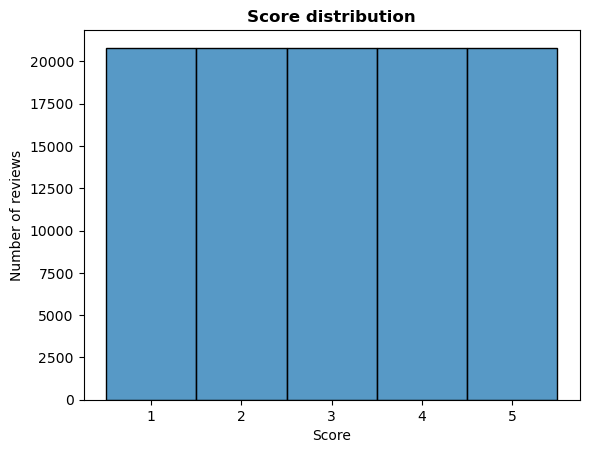

In [8]:
sns.histplot(df_downsampled['Score'], discrete=True)
plt.title("Score distribution", fontweight='bold')
plt.xlabel("Score")
plt.ylabel("Number of reviews")

In [9]:
# Eseguo uno shuffle dei dati

df_4_clustering = shuffle(df_downsampled, random_state = 123)
df_4_clustering.reset_index(drop=True, inplace=True)
df_4_clustering.head()

,Lemmatized Text,Score
0,"[heeded, warning, review, mentioned, leaking, ...",1
1,"[confirm, bone, cadet, small, piece, insidethe...",2
2,"[use, mann, steel, cut, meal, soaked, natural,...",5
3,"[using, tropical, fruit, year, still, great, t...",4
4,"[lover, coffee, really, robust, flavor, review...",2


In [10]:
# Divido x e y

x_clust = df_4_clustering['Lemmatized Text']
y_clust = df_4_clustering['Score']

# Clustering

## BOW

In [13]:
cv = CountVectorizer(min_df=0., max_df=1.0)
cv_model = cv.fit(x_clust.astype(str)) 
x_clust_BOW = cv_model.transform(x_clust.astype(str))

In [14]:
tSVD_BOW = TruncatedSVD(n_components = 1000)
SVD_BOW = tSVD_BOW.fit(x_clust_BOW)
x_clust_BOW = tSVD_BOW.transform(x_clust_BOW)
print(SVD_BOW.explained_variance_ratio_.sum())

0.7978902139128211


In [ ]:
# Normalizzo i dati

# x_clust_BOW_norm = preprocessing.normalize(x_clust_BOW)

### K-means

**Elbow method**: per individuare il numero ottimale di cluster, uno dei modi più utilizzati è quello di valuate l'inertia vs. n_cluster e considerare come numero ottimale quello che corrisponde all'**elbow point**.

https://towardsdatascience.com/clustering-how-to-find-hyperparameters-using-inertia-b0343c6fe819

L'inertia è definita come:

$\sum_{i=1}^N (x_i-C_k)^2$

dove N è il numero di campioni nel dataset e $C_k$ è il centroide del cluster. L'inertia, quindi, è la somma della distanza di ciascun dato del dataset dal centroide del cluster a cui appartiene: tale somma va minimizzata.

In [29]:
k=[2,3,4,5,6,7,8]
bow_inertia=[]
bow_silhouette_scores = []
bow_calinski_score = []
bow_davies_score = []
for i in k:
    model=KMeans(n_clusters=i, random_state=123)
    labels = model.fit_predict(x_clust_BOW)
    bow_inertia.append(model.inertia_)
    bow_silhouette_scores.append(sklearn.metrics.silhouette_score(x_clust_BOW, labels))
    bow_calinski_score.append(sklearn.metrics.calinski_harabasz_score(x_clust_BOW, labels))
    bow_davies_score.append(sklearn.metrics.davies_bouldin_score(x_clust_BOW, labels))
    print('Iteration complete')

Iteration complete
Iteration complete
Iteration complete
Iteration complete
Iteration complete
Iteration complete
Iteration complete


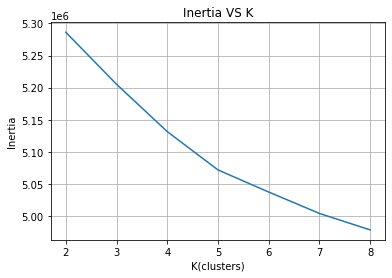

In [30]:
plt.plot(k, bow_inertia)
plt.xlabel('K(clusters)')
plt.ylabel('Inertia')
plt.title('Inertia VS K')
plt.grid()
plt.show()

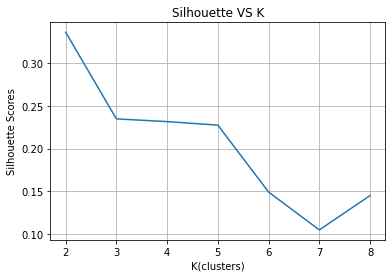

In [31]:
plt.plot(k, bow_silhouette_scores)
plt.xlabel('K(clusters)')
plt.ylabel('Silhouette Scores')
plt.title('Silhouette VS K')
plt.grid()
plt.show()

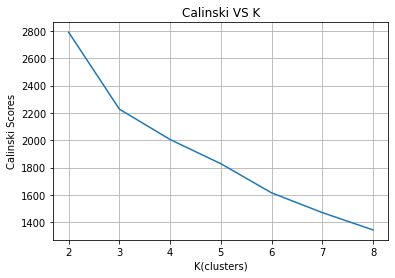

In [32]:
plt.plot(k, bow_calinski_score)
plt.xlabel('K(clusters)')
plt.ylabel('Calinski Scores')
plt.title('Calinski VS K')
plt.grid()
plt.show()

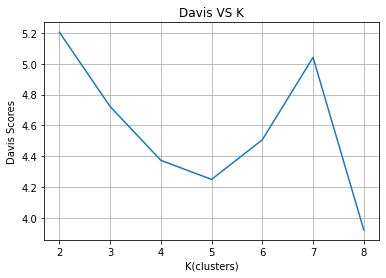

In [33]:
plt.plot(k, bow_davies_score)
plt.xlabel('K(clusters)')
plt.ylabel('Davis Scores')
plt.title('Davis VS K')
plt.grid()
plt.show()

In [ ]:
# Scelto il k ottimale, definisco il clustering

k_means = KMeans(n_clusters=5, max_iter=20, n_init=10, random_state=123)
k_means = k_means.fit(x_clust_BOW)

In [ ]:
# Creo delle liste contenete gli elementi dei vari cluster, così da fare delle word cloud e analisi specifiche per cluster

bow_cluster1,bow_cluster2,bow_cluster3,bow_cluster4,bow_cluster5=[],[],[],[],[]
for i in range(k_means.labels_.shape[0]):
    if k_means.labels_[i] == 0:
        bow_cluster1.append(x_clust[i])
    elif k_means.labels_[i] == 1:
        bow_cluster2.append(x_clust[i])
    elif k_means.labels_[i] == 2:
        bow_cluster3.append(x_clust[i])
    elif k_means.labels_[i] == 3:
        bow_cluster4.append(x_clust[i])
    else:
        bow_cluster5.append(x_clust[i])

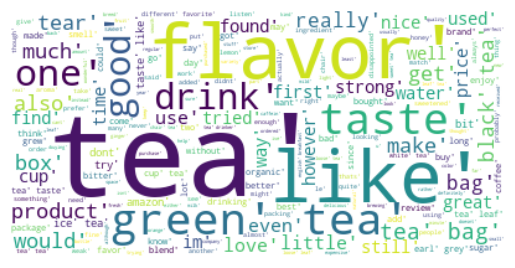

In [ ]:
# Cluster 1
data=''
for i in bow_cluster1:
    data+=str(i)

wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

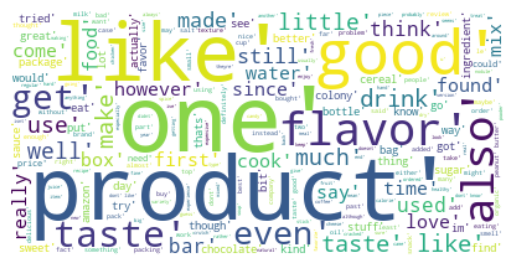

In [ ]:
# Cluster 2
data=''
for i in bow_cluster2:
    data+=str(i)

wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

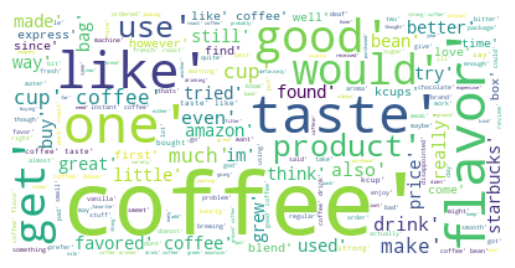

In [ ]:
# Cluster 3
data=''
for i in bow_cluster3:
    data+=str(i)

wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

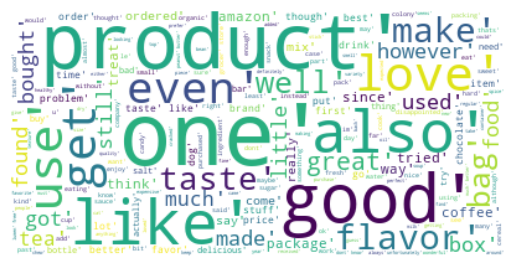

In [ ]:
# Cluster 4
data=''
for i in bow_cluster4:
    data+=str(i)

wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

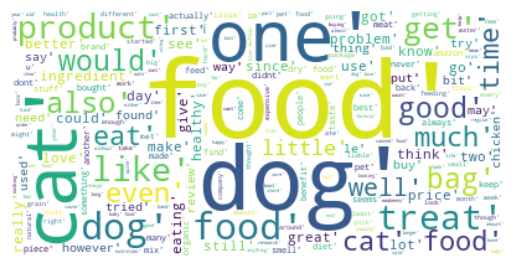

In [ ]:
# Cluster 5
data=''
for i in bow_cluster5:
    data+=str(i)

wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
cluster_list = [bow_cluster1, bow_cluster2, bow_cluster3, bow_cluster4, bow_cluster5]
print("Top 5 terms per cluster:")
for i in range(5):
    print("Cluster %d:" % (i+1), end='')
    flat_list = [item for sublist in cluster_list[i] for item in sublist]
    top5 = Counter(flat_list).most_common(5)
    for k in range(5):
        print(' %s' % top5[k][0], end='')
    print()

Top 5 terms per cluster:
Cluster 1: tea taste like flavor green
Cluster 2: like taste product one good
Cluster 3: coffee like taste cup flavor
Cluster 4: taste product like good one
Cluster 5: food dog cat like one


## TF-IDF

In [19]:
tv = TfidfVectorizer(min_df=0., max_df=1., use_idf=True)
tv_model = tv.fit(x_clust.astype(str))
x_clust_TFIDF = tv.transform(x_clust.astype(str))

In [20]:
tSVD_TFIDF = TruncatedSVD(n_components = 1000)
SVD_TFIDF = tSVD_TFIDF.fit(x_clust_TFIDF)
x_clust_TFIDF = tSVD_TFIDF.transform(x_clust_TFIDF)
print(SVD_TFIDF.explained_variance_ratio_.sum())

0.5645070559089014


In [ ]:
# Normalizzo i dati

# x_clust_TFIDF_norm = preprocessing.normalize(x_clust_TFIDF)

### K-means

In [21]:
k=[2,3,4,5,6,7,8]
tf_inertia=[]
tf_silhouette_scores = []
tf_calinski_score = []
tf_davies_score = []
for i in k:
    model=KMeans(n_clusters=i, random_state=123)
    labels = model.fit_predict(x_clust_TFIDF)
    tf_inertia.append(model.inertia_)
    tf_silhouette_scores.append(sklearn.metrics.silhouette_score(x_clust_TFIDF, labels))
    tf_calinski_score.append(sklearn.metrics.calinski_harabasz_score(x_clust_TFIDF, labels))
    tf_davies_score.append(sklearn.metrics.davies_bouldin_score(x_clust_TFIDF, labels))
    print('Iteration complete')

Iteration complete
Iteration complete
Iteration complete
Iteration complete
Iteration complete
Iteration complete
Iteration complete


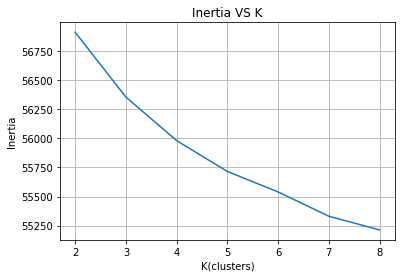

In [22]:
plt.plot(k, tf_inertia)
plt.xlabel('K(clusters)')
plt.ylabel('Inertia')
plt.title('Inertia VS K')
plt.grid()
plt.show()

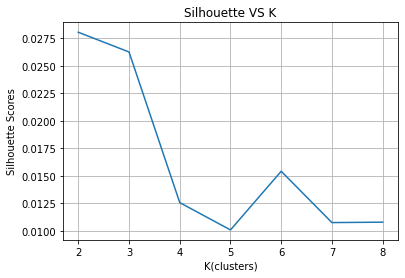

In [23]:
plt.plot(k, tf_silhouette_scores)
plt.xlabel('K(clusters)')
plt.ylabel('Silhouette Scores')
plt.title('Silhouette VS K')
plt.grid()
plt.show()

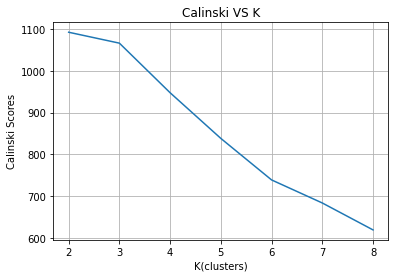

In [24]:
plt.plot(k, tf_calinski_score)
plt.xlabel('K(clusters)')
plt.ylabel('Calinski Scores')
plt.title('Calinski VS K')
plt.grid()
plt.show()

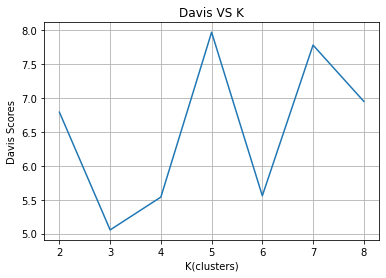

In [25]:
plt.plot(k, tf_davies_score)
plt.xlabel('K(clusters)')
plt.ylabel('Davis Scores')
plt.title('Davis VS K')
plt.grid()
plt.show()

In [ ]:
# Scelto il k ottimale, definisco il clustering

k_means = KMeans(n_clusters=6, max_iter=20, n_init=10, random_state=123)
k_means = k_means.fit(x_clust_TFIDF)

In [ ]:
tf_cluster1,tf_cluster2,tf_cluster3,tf_cluster4,tf_cluster5,tf_cluster6=[],[],[],[],[],[]
for i in range(k_means.labels_.shape[0]):
    if k_means.labels_[i] == 0:
        tf_cluster1.append(x_clust[i])
    elif k_means.labels_[i] == 1:
        tf_cluster2.append(x_clust[i])
    elif k_means.labels_[i] == 2:
        tf_cluster3.append(x_clust[i])
    elif k_means.labels_[i] == 3:
        tf_cluster4.append(x_clust[i])
    elif k_means.labels_[i] == 4:
        tf_cluster5.append(x_clust[i])
    else:
        tf_cluster6.append(x_clust[i])

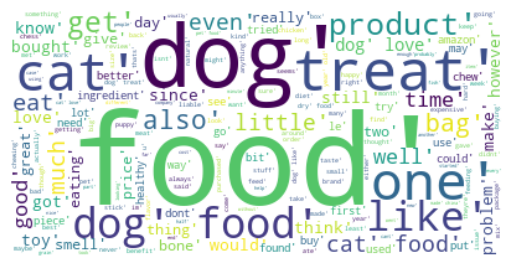

In [ ]:
# Cluster 1
data=''
for i in tf_cluster1:
    data+=str(i)

wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

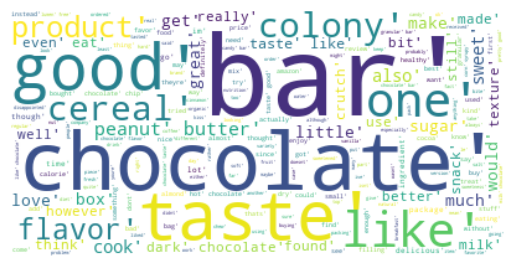

In [ ]:
# Cluster 2
data=''
for i in tf_cluster2:
    data+=str(i)

wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

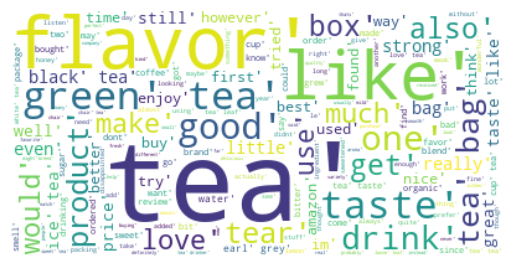

In [ ]:
# Cluster 3
data=''
for i in tf_cluster3:
    data+=str(i)

wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

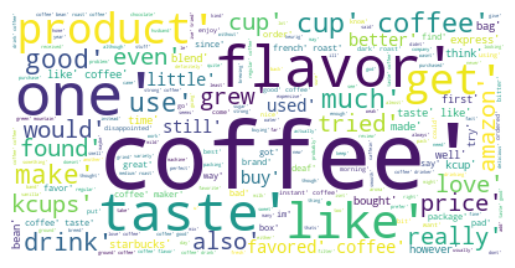

In [ ]:
# Cluster 4
data=''
for i in tf_cluster4:
    data+=str(i)

wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

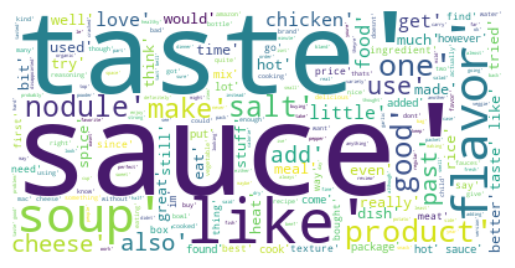

In [ ]:
# Cluster 5
data=''
for i in tf_cluster5:
    data+=str(i)

wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

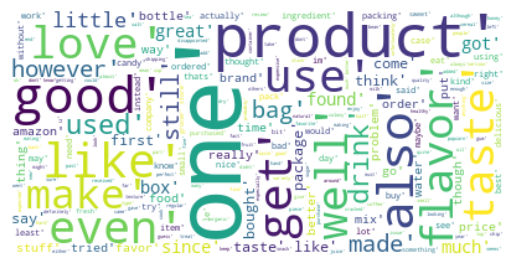

In [ ]:
# Cluster 6
data=''
for i in tf_cluster6:
    data+=str(i)

wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
cluster_list = [tf_cluster1, tf_cluster2, tf_cluster3, tf_cluster4, tf_cluster5, tf_cluster6]
print("Top 5 terms per cluster:")
for i in range(6):
    print("Cluster %d:" % (i+1), end='')
    flat_list = [item for sublist in cluster_list[i] for item in sublist]
    top5 = Counter(flat_list).most_common(5)
    for k in range(5):
        print(' %s' % top5[k][0], end='')
    print()

Top 5 terms per cluster:
Cluster 1: dog food cat treat like
Cluster 2: chocolate taste like bar good
Cluster 3: tea taste like flavor good
Cluster 4: coffee like taste cup good
Cluster 5: like sauce taste flavor good
Cluster 6: product like taste good one


## W2V

In [11]:
w2v_model = gensim.models.Word2Vec(x_clust, vector_size=300, window=8, min_count=2)
words = set(w2v_model.wv.index_to_key)

In [12]:
x_clust_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
                         for ls in x_clust])

In [13]:
x_clust_avg = []
for v in x_clust_vect:
    if v.size:
        x_clust_avg.append(v.mean(axis=0))
    else:
        x_clust_avg.append(np.zeros(300, dtype=float))

In [ ]:
# Normalizzo i dati

# x_clust_avg_norm = preprocessing.normalize(x_clust_avg)

### K-means

In [14]:
k=[2,3,4,5,6,7,8]
w2v_inertia=[]
w2v_silhouette_scores = []
w2v_calinski_score = []
w2v_davies_score = []
for i in k:
    model=KMeans(n_clusters=i, random_state=123)
    labels = model.fit_predict(x_clust_avg)
    w2v_inertia.append(model.inertia_)
    w2v_silhouette_scores.append(sklearn.metrics.silhouette_score(x_clust_avg, labels))
    w2v_calinski_score.append(sklearn.metrics.calinski_harabasz_score(x_clust_avg, labels))
    w2v_davies_score.append(sklearn.metrics.davies_bouldin_score(x_clust_avg, labels))

    print('Iteration complete')

Iteration complete
Iteration complete
Iteration complete
Iteration complete
Iteration complete
Iteration complete
Iteration complete


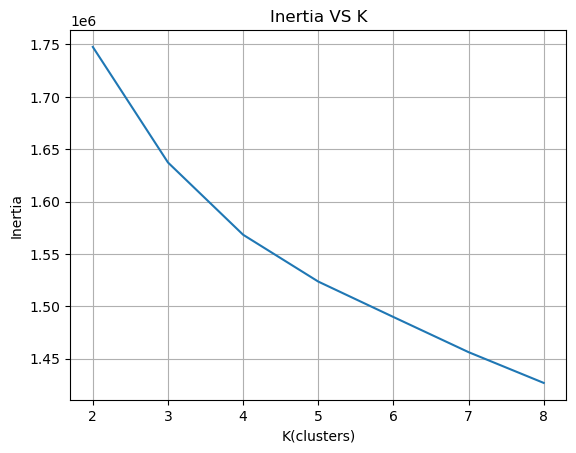

In [15]:
plt.plot(k, w2v_inertia)
plt.xlabel('K(clusters)')
plt.ylabel('Inertia')
plt.title('Inertia VS K')
plt.grid()
plt.show()

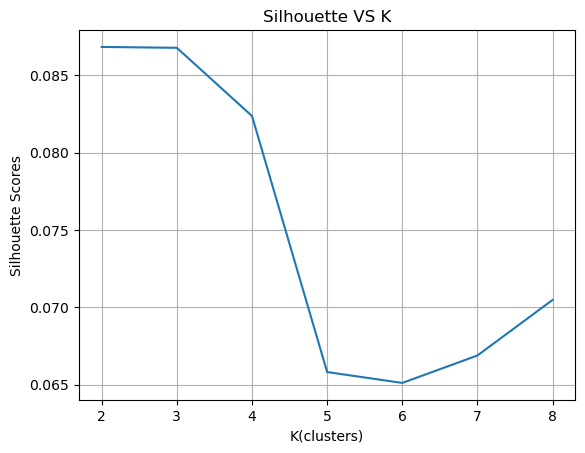

In [16]:
plt.plot(k, w2v_silhouette_scores)
plt.xlabel('K(clusters)')
plt.ylabel('Silhouette Scores')
plt.title('Silhouette VS K')
plt.grid()
plt.show()

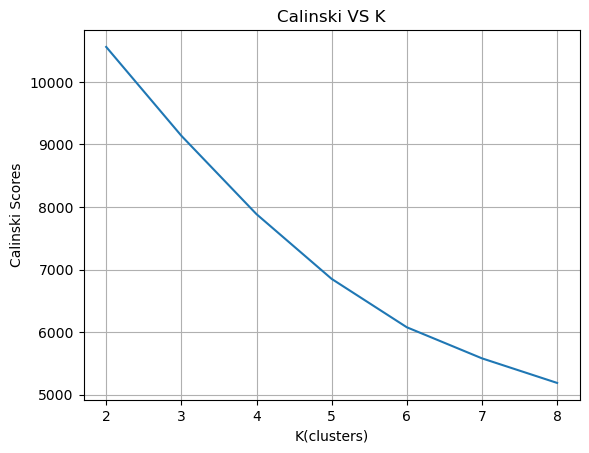

In [17]:
plt.plot(k, w2v_calinski_score)
plt.xlabel('K(clusters)')
plt.ylabel('Calinski Scores')
plt.title('Calinski VS K')
plt.grid()
plt.show()

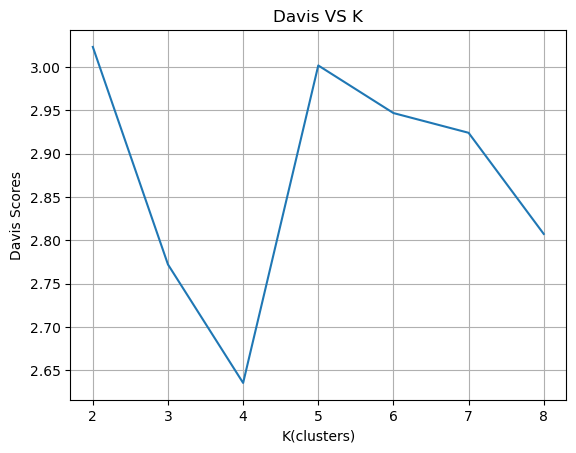

In [18]:
plt.plot(k, w2v_davies_score)
plt.xlabel('K(clusters)')
plt.ylabel('Davis Scores')
plt.title('Davis VS K')
plt.grid()
plt.show()

In [ ]:
# Scelto il k ottimale, definisco il clustering

k_means = KMeans(n_clusters=5, max_iter=20, n_init=10, random_state=123)
k_means = k_means.fit(x_clust_avg)

In [ ]:
w2v_cluster1,w2v_cluster2,w2v_cluster3,w2v_cluster4,w2v_cluster5=[],[],[],[],[]
for i in range(k_means.labels_.shape[0]):
    if k_means.labels_[i] == 0:
        w2v_cluster1.append(x_clust[i])
    elif k_means.labels_[i] == 1:
        w2v_cluster2.append(x_clust[i])
    elif k_means.labels_[i] == 2:
        w2v_cluster3.append(x_clust[i])
    elif k_means.labels_[i] == 3:
        w2v_cluster4.append(x_clust[i])
    else:
        w2v_cluster5.append(x_clust[i])

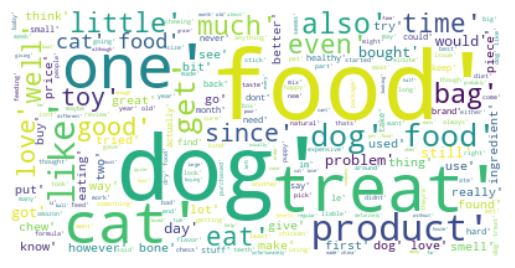

In [ ]:
# Cluster 1
data=''
for i in w2v_cluster1:
    data+=str(i)

wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

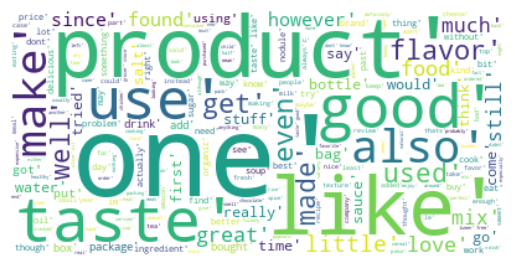

In [ ]:
# Cluster 2
data=''
for i in w2v_cluster2:
    data+=str(i)

wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

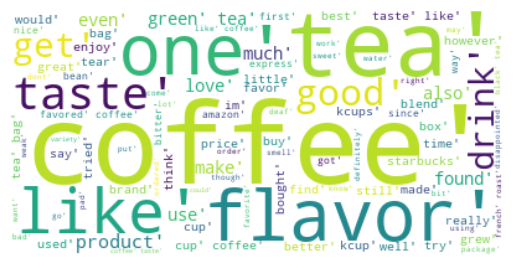

In [ ]:
# Cluster 3
data=''
for i in w2v_cluster3:
    data+=str(i)

wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

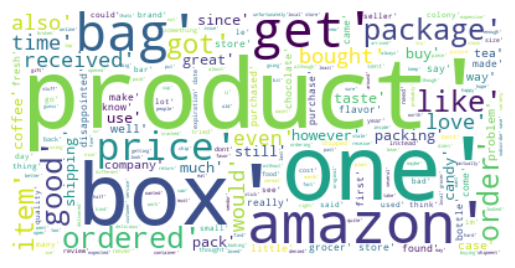

In [ ]:
# Cluster 4
data=''
for i in w2v_cluster4:
    data+=str(i)

wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

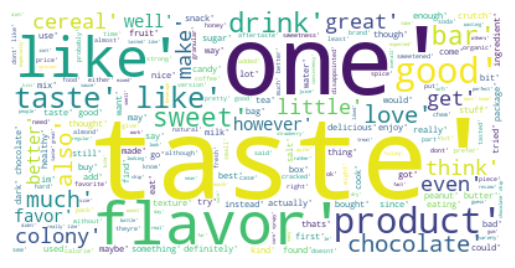

In [ ]:
# Cluster 5
data=''
for i in w2v_cluster5:
    data+=str(i)

wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
cluster_list = [w2v_cluster1, w2v_cluster2, w2v_cluster3, w2v_cluster4, w2v_cluster5]
print("Top 5 terms per cluster:")
for i in range(5):
    print("Cluster %d:" % (i+1), end='')
    flat_list = [item for sublist in cluster_list[i] for item in sublist]
    top5 = Counter(flat_list).most_common(5)
    for k in range(5):
        print(' %s' % top5[k][0], end='')
    print()

Top 5 terms per cluster:
Cluster 1: dog food cat treat like
Cluster 2: like product taste good one
Cluster 3: coffee tea taste like flavor
Cluster 4: product amazon box one price
Cluster 5: taste like flavor good chocolate


# Idee successive e utils

- Altri metodi di clustering (DBSCAN, Agglomerative clustering, ...)

- Link utili

Misure di performance: https://analyticsindiamag.com/a-tutorial-on-various-clustering-evaluation-metrics/